In [2]:
!pip install -q ultralytics
!pip install -q kaggle
!pip install -q opencv-python-headless
!pip install -q pillow
!pip install -q matplotlib
!pip install -q pandas
!pip install -q seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.5 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from datetime import datetime
import shutil
from pathlib import Path
import pandas as pd
import torch

In [7]:
import json, os

kaggle_json = {
    "username": "shalinimaurya13",
    "key": "KGAT_6013f9c3057ecbda1d7750bbc5bb6661"
}

os.makedirs("/root/.config/kaggle", exist_ok=True)

with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_json, f)

os.chmod("/root/.config/kaggle/kaggle.json", 600)

print("kaggle.json created successfully ")


kaggle.json created successfully 


In [8]:
!kaggle datasets list | head


ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                          Heart Disease                                             3491  2025-12-11 15:29:14.327000           2114        222  1.0              
ahmeduzaki/wind-and-solar-energy-production-dataset               Wind & Solar Energy Production Dataset                  395372  2026-01-02 21:06:22.780000              0         42  1.0              
kundanbedmutha/exam-score-prediction-dataset                      Exam Score Prediction Dataset                           325454  2025-11-28 07:29:01.047000           5863        262  1.0     

In [9]:
!kaggle datasets download -d akhatova/pcb-defects -p /content --force


Dataset URL: https://www.kaggle.com/datasets/akhatova/pcb-defects
License(s): unknown
 98% 1.84G/1.88G [00:22<00:00, 333MB/s]
100% 1.88G/1.88G [00:22<00:00, 90.2MB/s]


In [10]:
!unzip /content/pcb-defects.zip -d /content/pcb_dataset


Archive:  /content/pcb-defects.zip
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_01.xml  
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_02.xml  
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_03.xml  
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_04.xml  
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_05.xml  
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_06.xml  
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_07.xml  
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_08.xml  
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_09.xml  
  inflating: /content/pcb_dataset/PCB_DATASET/Annotations/Missing_hole/01_missing_hole_10.xml  
  inf

In [11]:
!ls /content/pcb_dataset


PCB_DATASET


In [12]:
!ls /content/pcb_dataset/PCB_DATASET


Annotations  images  PCB_USED  rotate.py  rotation


In [13]:
import os

# Define dataset path FIRST
dataset_path = "/content/pcb_yolo_dataset"

data_yaml_content = """
train: images/train
val: images/train



nc: 6
names: ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']
"""


os.makedirs(dataset_path, exist_ok=True)


with open(f'{dataset_path}/data.yaml', 'w') as f:
    f.write(data_yaml_content)

print(" data.yaml created successfully")


 data.yaml created successfully


YOLO folder structure

XML  to YOLO conversion

In [14]:
import os

base = "/content/pcb_yolo_dataset"

os.makedirs(f"{base}/images/train", exist_ok=True)
os.makedirs(f"{base}/images/val", exist_ok=True)
os.makedirs(f"{base}/labels/train", exist_ok=True)
os.makedirs(f"{base}/labels/val", exist_ok=True)

print(" YOLO folder structure ready")


 YOLO folder structure ready


In [15]:
IMG_DIR = "/content/pcb_dataset/PCB_DATASET/images"
ANN_DIR = "/content/pcb_dataset/PCB_DATASET/Annotations"
YOLO_DIR = "/content/pcb_yolo_dataset"


In [16]:
import os
import xml.etree.ElementTree as ET
import shutil
from collections import defaultdict

ROOT_DATASET = "/content/pcb_dataset/PCB_DATASET"
YOLO_DIR = "/content/pcb_yolo_dataset"
IMG_ROOT = os.path.join(ROOT_DATASET, "images")


os.makedirs(f"{YOLO_DIR}/images/train", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/train", exist_ok=True)


xml_files = []
for root, _, files in os.walk(ROOT_DATASET):
    for f in files:
        if f.lower().endswith(".xml"):
            xml_files.append(os.path.join(root, f))

print("Total XML files found:", len(xml_files))
if len(xml_files) == 0:
    raise Exception("NO XML FILES FOUND ANYWHERE IN PCB_DATASET")


def find_image(img_name):
    for root, _, files in os.walk(IMG_ROOT):
        if img_name in files:
            return os.path.join(root, img_name)
    return None

records = []          # (img_path, label, xmin, ymin, xmax, ymax, w, h)
class_set = set()


for xml_path in xml_files:
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except:
        continue

    # filename
    filename = None
    for e in root.iter():
        if e.tag.lower() == "filename":
            filename = e.text
            break
    if filename is None:
        continue

    img_path = find_image(filename)
    if img_path is None:
        continue

    # image size
    w = h = None
    for e in root.iter():
        if e.tag.lower() == "width":
            w = int(float(e.text))
        if e.tag.lower() == "height":
            h = int(float(e.text))
    if w is None or h is None:
        continue

    # objects
    for obj in root.iter():
        if obj.tag.lower() == "object":
            name = obj.findtext("name", default="defect")
            name = name.strip().lower().replace(" ", "_")

            box = obj.find("bndbox")
            if box is None:
                continue

            xmin = float(box.findtext("xmin"))
            ymin = float(box.findtext("ymin"))
            xmax = float(box.findtext("xmax"))
            ymax = float(box.findtext("ymax"))

            class_set.add(name)
            records.append((img_path, name, xmin, ymin, xmax, ymax, w, h))

print("Total parsed defect boxes:", len(records))
print("Classes found:", class_set)

if len(records) == 0:
    raise Exception(" XML FOUND but NO <object>/<bndbox> FOUND inside them")


classes = sorted(list(class_set))
class_map = {c: i for i, c in enumerate(classes)}
print("Class map:", class_map)


def to_yolo(xmin, ymin, xmax, ymax, w, h):
    return (
        (xmin + xmax) / 2 / w,
        (ymin + ymax) / 2 / h,
        (xmax - xmin) / w,
        (ymax - ymin) / h,
    )

stats = defaultdict(int)

for img_path, label, xmin, ymin, xmax, ymax, w, h in records:
    img_name = os.path.basename(img_path)
    shutil.copy(img_path, f"{YOLO_DIR}/images/train/{img_name}")

    label_file = f"{YOLO_DIR}/labels/train/{os.path.splitext(img_name)[0]}.txt"
    with open(label_file, "a") as f:
        yb = to_yolo(xmin, ymin, xmax, ymax, w, h)
        f.write(f"{class_map[label]} {' '.join(map(str, yb))}\n")
        stats[label] += 1

print(" YOLO conversion DONE")
print("Label stats:", dict(stats))


Total XML files found: 693
Total parsed defect boxes: 2953
Classes found: {'missing_hole', 'spur', 'spurious_copper', 'mouse_bite', 'open_circuit', 'short'}
Class map: {'missing_hole': 0, 'mouse_bite': 1, 'open_circuit': 2, 'short': 3, 'spur': 4, 'spurious_copper': 5}
 YOLO conversion DONE
Label stats: {'open_circuit': 482, 'mouse_bite': 492, 'short': 491, 'spurious_copper': 503, 'spur': 488, 'missing_hole': 497}


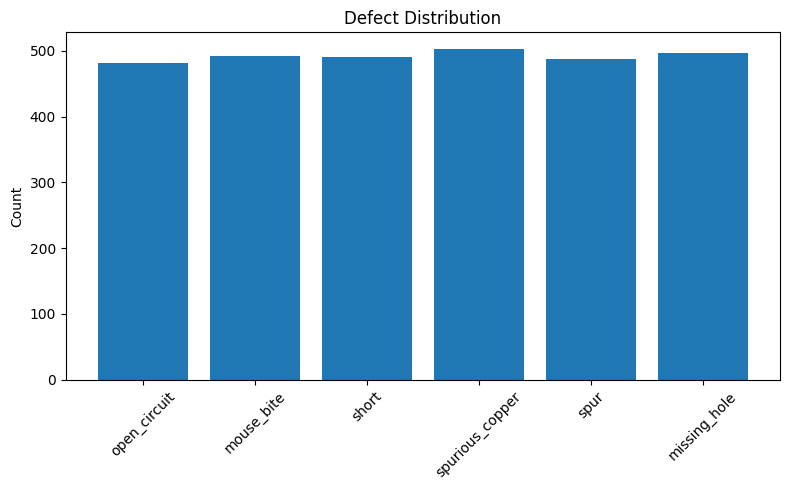

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(stats.keys(), stats.values())
plt.xticks(rotation=45)
plt.title("Defect Distribution")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


YOLOv8 TRAINING

In [18]:
from ultralytics import YOLO


In [19]:
def train_defect_detection_model(dataset_path, epochs=20):
    """
    Train YOLOv8 model for PCB defect detection
    """

    print(" Starting YOLOv8 training...")


    model = YOLO("yolov8n.pt")

    # Start training
    results = model.train(
        data=f"{dataset_path}/data.yaml",
        epochs=epochs,
        imgsz=640,
        batch=8,
        name="pcb_defect_detector",
        patience=10,
        save=True,
        plots=True,
        verbose=True
    )

    print(" Training completed successfully!")
    return model, results


In [20]:
dataset_path = "/content/pcb_yolo_dataset"

model, results = train_defect_detection_model(
    dataset_path=dataset_path,
    epochs=20
)


 Starting YOLOv8 training...
Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/pcb_yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pcb_defect_detector2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

In [2]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/pcb_defect_detector2/weights/best.pt")
print("✅ Model loaded successfully")


✅ Model loaded successfully


In [ ]:
results = model(
    "/content/pcb_yolo_dataset/images/train",
    save=True,
    conf=0.25
)



image 1/693 /content/pcb_yolo_dataset/images/train/01_missing_hole_01.jpg: 352x640 3 missing_holes, 78.4ms
image 2/693 /content/pcb_yolo_dataset/images/train/01_missing_hole_02.jpg: 352x640 3 missing_holes, 5.9ms
image 3/693 /content/pcb_yolo_dataset/images/train/01_missing_hole_03.jpg: 352x640 3 missing_holes, 5.9ms
image 4/693 /content/pcb_yolo_dataset/images/train/01_missing_hole_04.jpg: 352x640 3 missing_holes, 10.7ms
image 5/693 /content/pcb_yolo_dataset/images/train/01_missing_hole_05.jpg: 352x640 3 missing_holes, 6.0ms
image 6/693 /content/pcb_yolo_dataset/images/train/01_missing_hole_06.jpg: 352x640 3 missing_holes, 6.0ms
image 7/693 /content/pcb_yolo_dataset/images/train/01_missing_hole_07.jpg: 352x640 3 missing_holes, 6.0ms
image 8/693 /content/pcb_yolo_dataset/images/train/01_missing_hole_08.jpg: 352x640 3 missing_holes, 5.9ms
image 9/693 /content/pcb_yolo_dataset/images/train/01_missing_hole_09.jpg: 352x640 3 missing_holes, 6.3ms
image 10/693 /content/pcb_yolo_dataset/imag

In [1]:
!ls /content/runs/detect/predict | head


01_missing_hole_01.jpg
01_missing_hole_02.jpg
01_missing_hole_03.jpg
01_missing_hole_04.jpg
01_missing_hole_05.jpg
01_missing_hole_06.jpg
01_missing_hole_07.jpg
01_missing_hole_08.jpg
01_missing_hole_09.jpg
01_missing_hole_10.jpg


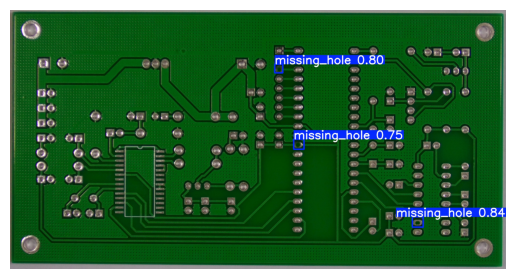

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os

img_dir = "/content/runs/detect/predict"
img_name = "01_missing_hole_01.jpg"  # koi bhi ek choose kar lo

img = Image.open(os.path.join(img_dir, img_name))
plt.imshow(img)
plt.axis("off")
plt.show()
